In [33]:
import polars as pl
import pandas as pd
from random import sample
from functools import reduce
import multiprocessing as mp
from collections import Counter
from collections import defaultdict

from tqdm import tqdm
import matplotlib.pyplot as plt

from tools.utils.parallel import chunks
from tools.utils.datalake import SimpleDataLakeHelper
from tools.utils.misc import table_rows_to_columns, table_to_tokens

In [37]:
analyses_dir = '/data4/nanni/tesi-magistrale/experiments/multi_key_join/wikiturlsnap'

# Time Analyses

In [16]:
multi_keys = [
    'city-province',
    'club-stadium',
    'city-club', 
    'city-country'
]
multi_key = multi_keys[2]

T = 0.9
N = 300
K = 50

josie_mc = pd.read_csv(f'/data4/nanni/tesi-magistrale/experiments/multi_key_join/analyses/{multi_key}/N{N}_K{K}_T{T}/results_multi_josie.csv')
josie_bl = pd.read_csv(f'/data4/nanni/tesi-magistrale/experiments/multi_key_join/analyses/{multi_key}/N{N}_K{K}_T{T}/results_single_josie.csv')
multi_key

'city-club'

In [17]:
josie_bl[['query_id', 'duration',  'num_set_read', 'num_list_read', 'max_set_size_read', 'max_list_size_read', ]].groupby('query_id').sum().describe()

,duration,num_set_read,num_list_read,max_set_size_read,max_list_size_read
count,300.000000,300.000000,300.000000,300.000000,300.000000
mean,11.386667,0.976667,24.693333,15.053333,2495.206667
std,20.947869,6.115072,10.928743,151.177797,10965.799783
min,0.000000,0.000000,5.000000,0.000000,38.000000
25%,4.000000,0.000000,17.000000,0.000000,373.750000
50%,7.000000,0.000000,24.000000,0.000000,867.500000
75%,11.000000,0.000000,32.000000,0.000000,2193.250000
max,261.000000,51.000000,81.000000,2520.000000,157814.000000


In [18]:
josie_mc[['duration', 'num_set_read', 'num_list_read', 'max_set_size_read', 'max_list_size_read']].describe()

,duration,num_set_read,num_list_read,max_set_size_read,max_list_size_read
count,300.00000,300.000000,300.000000,300.000000,300.000000
mean,12.88000,4.546667,24.346667,64.376667,1930.460000
std,21.50365,12.257596,11.005311,220.986965,7139.920304
min,1.00000,0.000000,5.000000,0.000000,29.000000
25%,4.00000,0.000000,17.000000,0.000000,327.000000
50%,8.00000,1.000000,23.000000,8.500000,563.500000
75%,13.00000,3.000000,32.000000,37.250000,1763.250000
max,232.00000,116.000000,81.000000,2405.000000,78907.000000


# Other Analyses

## How many results are returned by BSL and MC? And how many results of BSL are included by those from MC? 

In [39]:
# multi_keys = ['city-province', 'city-club', 'club-stadium', 'city-country']

multi_keys = ['party-member', 'home-road', 'director-genre']

N = 300
K = 50
min_h_values = [0.6, 0.9]
k_values = [1, 5, 10, 20, 30]
strange = []


director-genre has not 100 results: 73


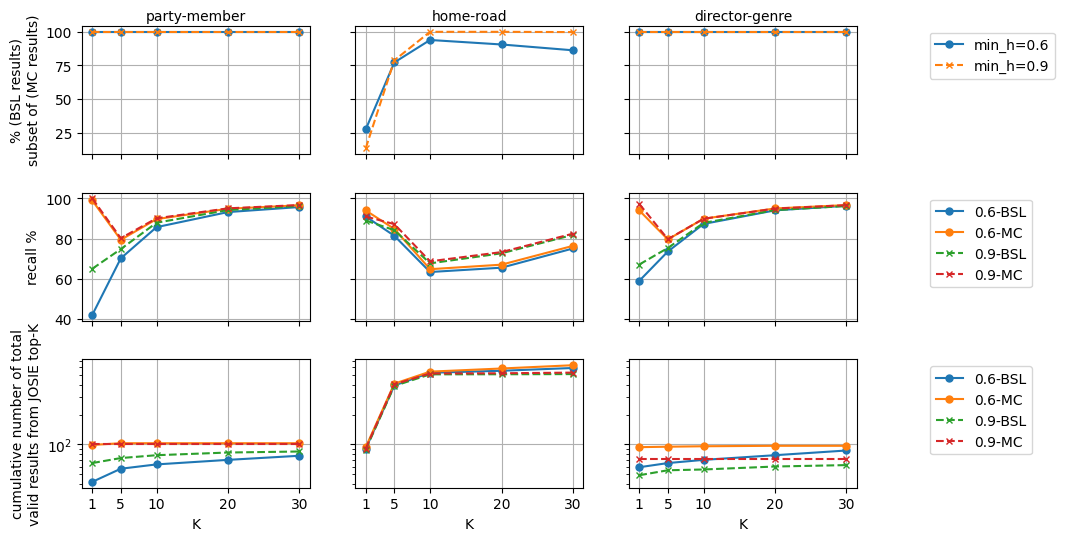

In [40]:
from random import sample
from statistics import mean

from tools.utils.metrics import relevance_precision_at_k


fig, (axs, axs_rec, axs_num_res) = plt.subplots(3, len(multi_keys), sharey='row', sharex='col', figsize=(10, 6))
plt.subplots_adjust(hspace=0.3)
actually_used_query_ids = []
for multi_key, ax, axrec, axnr in zip(multi_keys, axs, axs_rec, axs_num_res):
    for min_h, line, color in zip(min_h_values, ['-o', '--x'], ['tab:blue', 'tab:orange']):
        results = pl.read_csv(f'{analyses_dir}/{multi_key}/N{N}_K{K}_T{min_h}/final_results.csv')

        # take only those queries that have at least one accepted candidate
        # from these, select only the first 100
        nresults = 100
        analyses_results = [
            q[0] for q, group in results.group_by('query_id') 
            if any(group.select('SLOTH_columns_overlap').filter(pl.col('SLOTH_columns_overlap') > 0).rows())
        ][:nresults]
        if len(analyses_results) < nresults:
            print(f'{multi_key} has not {nresults} results: {len(analyses_results)}')
        results = results.filter(pl.col('query_id').is_in(analyses_results))
        
        for q in analyses_results:
            actually_used_query_ids.append(q)
        
        # compute the recall (0/1 values with meaning "not valid/valid candidate")
        final_bsl_rec, final_mc_rec = [], []

        for k in k_values:
            bsl_rec, mc_rec = [], []

            for q, qgroup in results.group_by('query_id'):
                qgroup = qgroup.with_columns((pl.col('SLOTH_columns_overlap') > 0).cast(pl.Int8))

                silver_standard = qgroup.sort(by='SLOTH_columns_overlap', descending=True).select('SLOTH_columns_overlap').to_series().to_list()
                
                bsl_results = qgroup.filter(pl.col('version') == 'baseline').select('SLOTH_columns_overlap').to_series().to_list()
                mc_results = qgroup.filter(pl.col('version') == 'MC').select('SLOTH_columns_overlap').to_series().to_list()
                
                bsl_rec.append(relevance_precision_at_k(silver_standard, bsl_results, k))
                mc_rec.append(relevance_precision_at_k(silver_standard, mc_results, k))
                if bsl_rec[-1] > mc_rec[-1]: # to keep track of cases where BSL got better than MC
                    strange.append([multi_key, q])

            final_bsl_rec.append(100 * mean(bsl_rec))
            final_mc_rec.append(100 * mean(mc_rec))

        baseline = results.filter((pl.col('version') == 'baseline') & (pl.col('SLOTH_columns_overlap') > 0))
        mc = results.filter((pl.col('version') == 'MC') & (pl.col('SLOTH_columns_overlap') > 0))

        # compute the cumulative number of total valid results for both BSL and MC
        # and the % of BSL results that is a subset of the MC results (--> this btw doens't tell much about
        # values that BSL only discovered)
        num_res_com = []
        subset_perc = []
        for k in k_values:
            baseline_res_ids =  set(baseline.filter(pl.col('result_rank') < k).select('query_id', 'result_id').rows())
            mc_res_ids =        set(mc.filter(pl.col('result_rank') < k).select('query_id', 'result_id').rows())
            
            n_baseline, n_mc = len(baseline_res_ids), len(mc_res_ids)
            
            n_difference = len(baseline_res_ids.difference(mc_res_ids))
            n_subset = len(baseline_res_ids.intersection(mc_res_ids))

            num_res_com.append([n_baseline, n_mc])
            subset_perc.append(round(100 * n_subset / n_baseline, 3))
        
        ax.plot(k_values, subset_perc, line, color=color, label=f'min_h={min_h}', markersize=5)

        for r, label in [[final_bsl_rec, 'BSL'], [final_mc_rec, 'MC']]:
             axrec.plot(k_values, r, line, label=f'{min_h}-{label}', markersize=5)

        for i, w in zip([0, 1], ['BSL', 'MC']):
            axnr.plot(k_values, [n[i] for n in num_res_com], line, label=f'{min_h}-{w}', markersize=5)

    ax.set_xlabel(multi_key)
    ax.xaxis.set_label_position('top')
    axnr.set_xlabel(f"K")
    
    ax.grid(True)
    axrec.grid(True)
    axnr.grid(True)

    ax.set_xticks(k_values)
    axnr.set_xticks(k_values)
    axnr.set_yscale('log')


axs[0].set_ylabel('% (BSL results)\nsubset of (MC results)')
axs_rec[0].set_ylabel('recall %')
axs_num_res[0].set_ylabel('cumulative number of total\nvalid results from JOSIE top-K')

axs[-1].legend(loc='best', bbox_to_anchor=(0., 0., 1.9, 1))
axs_rec[-1].legend(loc='best', bbox_to_anchor=(0., 0., 1.8, 1))
axs_num_res[-1].legend(loc='best', bbox_to_anchor=(0., 0., 1.8, 1))
fig.show()

In [62]:
strange[:3]

[['actor-role', (22959,)], ['actor-role', (22959,)], ['actor-role', (22959,)]]

In [35]:
from tools.utils.metrics import recall_at_k

min_h = 0.9
bsl_rec = []
mc_rec = []
multi_key = 'city-province'
k =50
results = pl.read_csv(f'{analyses_dir}/{multi_key}/N{N}_K{K}_T{min_h}/final_results.csv').filter(pl.col('query_id') == 399284)

results = results.with_columns((pl.col('SLOTH_columns_overlap') > 0).cast(pl.Int8))

silver_standard = results.sort(by='SLOTH_columns_overlap', descending=True).select('SLOTH_columns_overlap').to_series().unique().to_list()
bsl_results = results.filter(pl.col('version') == 'baseline').select('SLOTH_columns_overlap').to_series().to_list()
mc_results = results.filter(pl.col('version') == 'MC').select('SLOTH_columns_overlap').to_series().to_list()

bsl_rec = recall_at_k(silver_standard[:k], bsl_results, k)
mc_rec = recall_at_k(silver_standard[:k], mc_results, k)

bsl_rec, mc_rec

(0.5, 0.5)

## Is there any case where BSL find valid candidates and MC not?

In [63]:
for min_h in min_h_values:
    qids = []
    for multi_key in multi_keys:
        results = pl.read_csv(f'{analyses_dir}/{multi_key}/N{N}_K{K}_T{min_h}/final_results.csv').filter(pl.col('SLOTH_columns_overlap') > 0)
        for qid, qgroup in results.group_by('query_id'):
            nres_bsl = qgroup.filter(pl.col('version') == 'baseline').shape[0]
            nres_mc  = qgroup.filter(pl.col('version') == 'MC').shape[0]
            if nres_bsl > nres_mc:
                qids.append([multi_key, qid])
    print(f'min_h = {min_h}')
    print(qids)

min_h = 0.6
[['actor-role', (16667,)]]
min_h = 0.9
[['actor-role', (53991,)], ['actor-role', (53986,)], ['actor-role', (53924,)], ['actor-role', (53984,)], ['actor-role', (53996,)]]


## How big are the attributes domains (only from queries)?

In [30]:
dlh = SimpleDataLakeHelper('mongodb', 'wikiturlsnap', 'standard')


N = 300
K = 50
T = 0.9

domains_set = defaultdict(set)
domains_bag = defaultdict(set)

for multi_key in multi_keys:
    mk_results = pl.read_csv(f"{analyses_dir}/{multi_key}/N{N}_K{K}_T{T}/final_results.csv")
    keys = multi_key.split('-')
    for qid in tqdm(mk_results.select('query_id').rows()):
        if qid[0] not in actually_used_query_ids:
            continue
        table_obj = dlh.get_table_by_numeric_id(qid[0])
        bad_columns = table_obj['numeric_columns']
        headers = [str(h).lower().strip() for h in (table_obj['headers'] if table_obj['headers'] != None else table_obj['content'][0])]
        table = table_rows_to_columns(table_obj['content'], 0, len(table_obj['content'][0]), bad_columns)

        for header, column, is_bad in zip(headers, table, bad_columns):
            if not is_bad:
                for key in keys:
                    if header == key:
                        for token in table_to_tokens([column], 'set', [0] * len(column)):
                            domains_set[key].add(token)
                        for token in table_to_tokens([column], 'bag', [0] * len(column)):
                            domains_bag[key].add(token)

  2%|▏         | 306/18800 [00:00<00:14, 1253.72it/s]

100%|██████████| 30000/30000 [00:07<00:00, 3781.93it/s]


In [31]:
data = [[k, len(domains_set[k]), len(domains_bag[k])] for k in domains_set.keys()]
pl.DataFrame(data, schema=['attribute', 'set_query_domain_size', 'bag_query_domain_size'], orient='row')

attribute,set_query_domain_size,bag_query_domain_size
str,i64,i64
"""province""",599,2214
"""city""",3506,4555
"""club""",2199,2234
"""stadium""",1417,1550
"""country""",704,1278


## How are distributed the attribute domains across all the tables?

In [68]:
def initializer(_domains_set:defaultdict):
    global domains_set
    domains_set = _domains_set


def task(data):
    global domains_set
    dlh = SimpleDataLakeHelper('mongodb', 'wikiturlsnap', 'standard')
    tobj_range = data[0]
    set_domain_freq = defaultdict(int)

    for i in tobj_range:
        tobj = dlh.get_table_by_numeric_id(i)
        tset = table_to_tokens(tobj['content'], 'set', tobj['numeric_columns'])
        
        for attr, values in domains_set.items():
            if any(x in tset for x in values):
                set_domain_freq[attr] += 1
        
    return Counter(set_domain_freq)


def update_counter(a, b):
    a.update(b)
    return a

p = 32
n = 100_000

with mp.Pool(p, initializer, (domains_set, )) as pool:
    work = sample(range(dlh.get_number_of_tables()), n)
    set_domain_freq = pool.map(task, chunks(work, len(work) // p))
    set_domain_freq = reduce(update_counter, set_domain_freq)


In [69]:
data = [[k, set_domain_freq[k], round(100 * set_domain_freq[k] / n, 1)] for k in set_domain_freq.keys()]
pl.DataFrame(data, schema=['attribute', 'set_frequency', f'set_frequency (% {n})'], orient='row')

attribute,set_frequency,set_frequency (% 100000)
str,i64,f64
"""nationality""",13966,14.0
"""name""",12266,12.3
"""genre""",8909,8.9
"""director""",10219,10.2
"""role""",6697,6.7
"""actor""",1429,1.4


## Is there any overlap among the domains?

There is a functional dependency between the selected attribute pairs? If so, then may be better to select other pairs of attributes

In [32]:
attributes = list(domains_set.keys())
data = []
for i, attr in enumerate(attributes):
    for attr2 in attributes[i+1:]:
        data.append([attr, attr2,
                     len(domains_set[attr]), len(domains_set[attr2]),
                     len(domains_set[attr].intersection(domains_set[attr2])), round(100 * len(domains_set[attr].intersection(domains_set[attr2])) / min(len(domains_set[attr]), len(domains_set[attr2]))),
                     len(domains_bag[attr]), len(domains_bag[attr2]),
                     len(domains_bag[attr].intersection(domains_bag[attr2])), round(100 * len(domains_bag[attr].intersection(domains_bag[attr2])) / min(len(domains_bag[attr]), len(domains_bag[attr2])))
                     ])
pl.DataFrame(data, schema=['attr_A', 'attr_B', '#set_attr_A', '#set_attr_B', 'set_overlap', 'set_overlap (%)', '#bag_attr_A', '#bag_attr_B', 'bag_overlap', 'bag_overlap (%)'], orient='row')

attr_A,attr_B,#set_attr_A,#set_attr_B,set_overlap,set_overlap (%),#bag_attr_A,#bag_attr_B,bag_overlap,bag_overlap (%)
str,str,i64,i64,i64,i64,i64,i64,i64,i64
"""province""","""city""",599,3506,117,20,2214,4555,228,10
"""province""","""club""",599,2199,16,3,2214,2234,19,1
"""province""","""stadium""",599,1417,1,0,2214,1550,5,0
"""province""","""country""",599,704,1,0,2214,1278,1,0
"""city""","""club""",3506,2199,172,8,4555,2234,184,8
"""city""","""stadium""",3506,1417,6,0,4555,1550,6,0
"""city""","""country""",3506,704,139,20,4555,1278,213,17
"""club""","""stadium""",2199,1417,7,0,2234,1550,9,1
"""club""","""country""",2199,704,29,4,2234,1278,30,2


## Why there are candidates that are found by BSL but not by MC?

In [27]:
multi_keys = [
    'city-province',
    'club-stadium',
    'city-club', 
    'city-country'
]
multi_key = multi_keys[3]

T = 0.9
N = 300
K = 50

results = pl.read_csv(f'/data4/nanni/tesi-magistrale/experiments/multi_key_join/analyses/{multi_key}/N{N}_K{K}_T{T}/final_results.csv')

In [28]:
query_ids = results.select('query_id').to_series().unique().to_list()
query_ids[:10]

[145, 740, 1983, 2063, 3558, 4044, 4553, 4554, 4555, 4558]

In [29]:
strange = []
for i, qid in enumerate(query_ids):
    rn = results.filter((pl.col('query_id') == qid) & (pl.col('SLOTH_columns_overlap') > 0)).shape[0]
    if rn > 0 and rn % 2 != 0:
        strange.append(qid)

In [30]:
qid = strange[2]
d = results.filter((pl.col('query_id') == qid) & (pl.col('SLOTH_columns_overlap') > 0))

With the query id 124771 we can see that there are some results that aren't included in the MC version: the tables 1222698 and 1080321 provides both a rectangular overlap of 14 with the query table (wrt to its query columns) but they are not considered by the top-50 of the MC version, becouse there are others tables with a set overlap of 7 like them, which accidentally where selected before during the search

In [31]:
d.filter(pl.col('version') == 'baseline')

version,query_id,result_id,result_rank,JOSIE_overlap,SLOTH_columns_overlap
str,i64,i64,i64,i64,i64
"""baseline""",8770,1290079,45,24,24
"""baseline""",8770,791916,46,24,24
"""baseline""",8770,2266365,47,22,22


In [32]:
d.filter(pl.col('version') == 'MC')

version,query_id,result_id,result_rank,JOSIE_overlap,SLOTH_columns_overlap
str,i64,i64,i64,i64,i64
"""MC""",8770,791916,0,25,24
"""MC""",8770,1290079,1,25,24
"""MC""",8770,1127113,2,24,22
"""MC""",8770,1111214,3,24,22
"""MC""",8770,923374,4,24,22
"""MC""",8770,1270027,5,24,22
"""MC""",8770,2266365,6,24,22
"""MC""",8770,916875,7,24,22
"""MC""",8770,1919058,9,24,22


In [86]:
results.filter((pl.col('version') == 'MC') & (pl.col('query_id') == 124771)).tail(15)

version,query_id,result_id,result_rank,JOSIE_overlap,SLOTH_columns_overlap
str,i64,i64,i64,i64,i64
"""MC""",124771,26883,35,8,-2
"""MC""",124771,1378058,36,8,-2
"""MC""",124771,1544311,37,8,-2
"""MC""",124771,550572,38,7,-2
"""MC""",124771,1363667,39,7,-2
…,…,…,…,…,…
"""MC""",124771,466519,45,7,-2
"""MC""",124771,16944,46,7,-2
"""MC""",124771,34090,47,7,-2
